## Build anndata from `cellatac` output

In this notebook we put together the many outputs of the [cellatac pipeline](https://github.com/cellgeni/cellatac) for peak calling in scATAC-seq data into one handy anndata object, we do some important peak filtering

In [1]:
import numpy as np
import scipy.sparse
import pandas as pd 
import scanpy as sc
import os

In [2]:
import session_info
session_info.show()

In [3]:
experiment_prefix = '6reg-v2_ATACs_with_SAN'

### tic-1158

In [4]:
outdir_1158 = "/nfs/team205/kk18/data/6region_v2/ATAC/tic-1158"
cellatac_outdir_1158 = '/nfs/team205/heart/cellatac/tic-1158/results200k/'

In [5]:
input={'cnts': cellatac_outdir_1158 + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir_1158 + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir_1158 + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir_1158 + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir_1158 + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir_1158 + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir_1158 + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir_1158 + experiment_prefix + '_ATAC_raw.h5ad',
}

### Make anndata object (tic-1158)

In [ ]:
%%time
ad = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header = None)
feat = pd.read_table(input["peaks"], header = None)

ad.obs_names = bc[0]
ad.var_names = feat[0]
ad

In [ ]:
# check no duplicates in cell_ids
len(ad.obs_names) == len(set(ad.obs_names))

### Load peak annotations computed with `annotate_peaks.R` (tic-1158)

In [ ]:
# peak_anno_df = pd.read_csv(outdir + "ATACpeaks_annotation.csv", index_col = 0)
# peak_anno_df = pd.read_csv("/nfs/team205/heart/cellatac/tic-1158/ATACpeaks_annotation.csv", index_col = 0)
peak_anno_df = pd.read_csv("/lustre/scratch117/cellgen/team205/dm19/kazu/notebooks/annotate_peaks/ATACpeaks_annotation.csv", index_col = 0)

peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace = True)

ad.var = pd.concat([ad.var, peak_anno_df], 1)
ad

In [ ]:
ad.var.head()

In [ ]:
np.max(ad.X.data)

### Save binary data to layers (tic-1158)

In [ ]:
ad.layers["binary_raw"] = ad.X
ad.layers["binary_raw"][ad.layers["binary_raw"] > 1] = 1 # change to binary
ad

In [ ]:
np.max(ad.X.data)

In [ ]:
np.sum(ad.var['ENCODE_blacklist'] != 0)

### Peak filtering

`cellatac` calls a lot of peaks that are just noisy and downsizing the matrix a bit makes everything faster.

#### OBS: Check the filters for your data carefully so you don't throw away usueful info.

In [6]:
ad = sc.read_h5ad('/lustre/scratch117/cellgen/team205/dm19/kazu/notebooks/6regions_with_SAN/adata2.h5ad')

In [7]:
ad

AnnData object with n_obs × n_vars = 155699 × 377337
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist'
    layers: 'binary_raw'

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

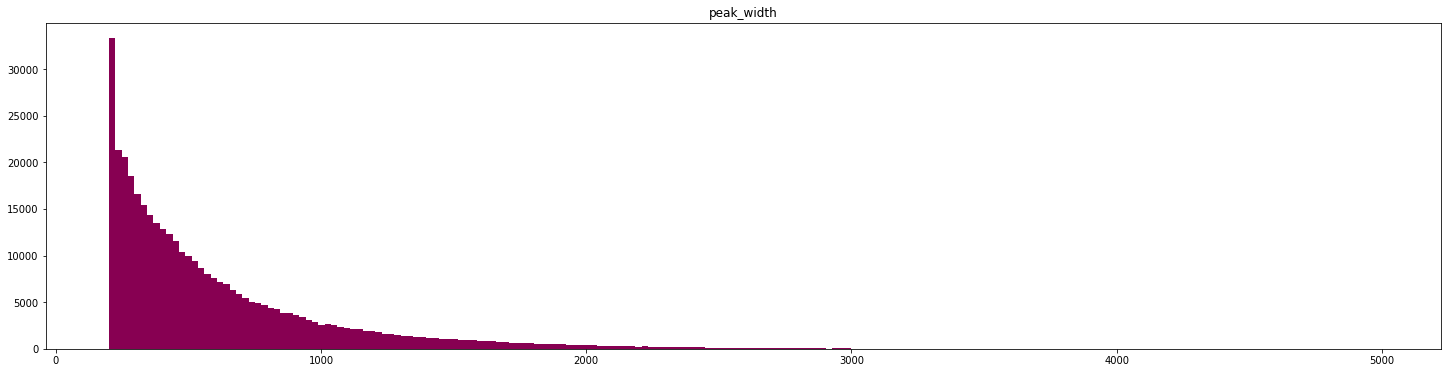

In [8]:
ad.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

In [9]:
np.min(ad.var['peak_width'])

201

### Preliminary filtering

- Basic QC

In [10]:
var_qc = sc.pp.calculate_qc_metrics(ad, layer = "binary_raw")[1]
ad.var = pd.concat([ad.var, var_qc], 1) 
ad

AnnData object with n_obs × n_vars = 155699 × 377337
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [11]:
ad.var.head()

,peak_width,exon,gene,promoter,annotation,gene_name,gene_id,tss_distance,ENCODE_blacklist,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
chr1:10054-10373,320,0,0,0,intergenic,nan,nan,58717,1,969,0.006224,0.006204,99.377645,969.0,6.877296
chr1:180687-181608,922,0,0,1,promoter,FO538757.2,ENSG00000279928,784,1,4667,0.029975,0.029534,97.002550,4667.0,8.448486
chr1:184067-184543,477,1,1,0,exon,FO538757.2,ENSG00000279928,1673,1,946,0.006076,0.006057,99.392417,946.0,6.853299
chr1:191218-191625,408,0,1,0,intron,FO538757.1,ENSG00000279457,3785,1,2785,0.017887,0.017729,98.211292,2785.0,7.932362
chr1:267873-268085,213,0,0,0,intergenic,nan,nan,67550,1,757,0.004862,0.004850,99.513805,757.0,6.630683


- Remove cells with peaks accessible in less than k cells

array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

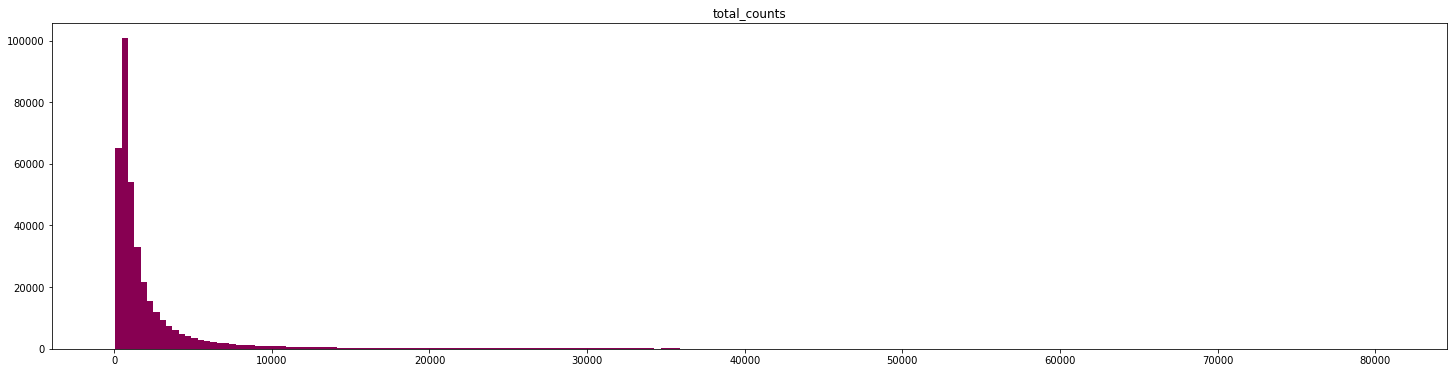

In [12]:
ad.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')
# total counts in var: total reads (from binary data) per peak 

In [ ]:
# make a copy to come back
# adata_prefilter = adata.copy()

In [ ]:
# adata = adata_prefilter.copy()

(array([2.38990e+04, 4.74000e+02, 2.19600e+03, 1.27450e+04, 5.36430e+04,
        1.29785e+05, 1.10453e+05, 4.15340e+04, 2.58700e+03, 2.10000e+01]),
 array([0.        , 0.74949534, 1.49899067, 2.24848601, 2.99798134,
        3.74747668, 4.49697201, 5.24646735, 5.99596268, 6.74545802,
        7.49495335]),
 <BarContainer object of 10 artists>)

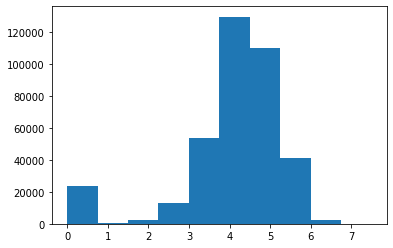

In [13]:
import matplotlib.pyplot as plt

plt.hist(np.log10(ad.var.tss_distance + 1))

In [14]:
ad = ad[:,ad.var.total_counts > 30]
ad = ad[:,ad.var.total_counts < 6000]
ad

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 155699 × 342371
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [15]:
ad = ad[:,ad.var.tss_distance < 50000]

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [16]:
ad

View of AnnData object with n_obs × n_vars = 155699 × 228169
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

array([[<AxesSubplot:title={'center':'total_counts'}>]], dtype=object)

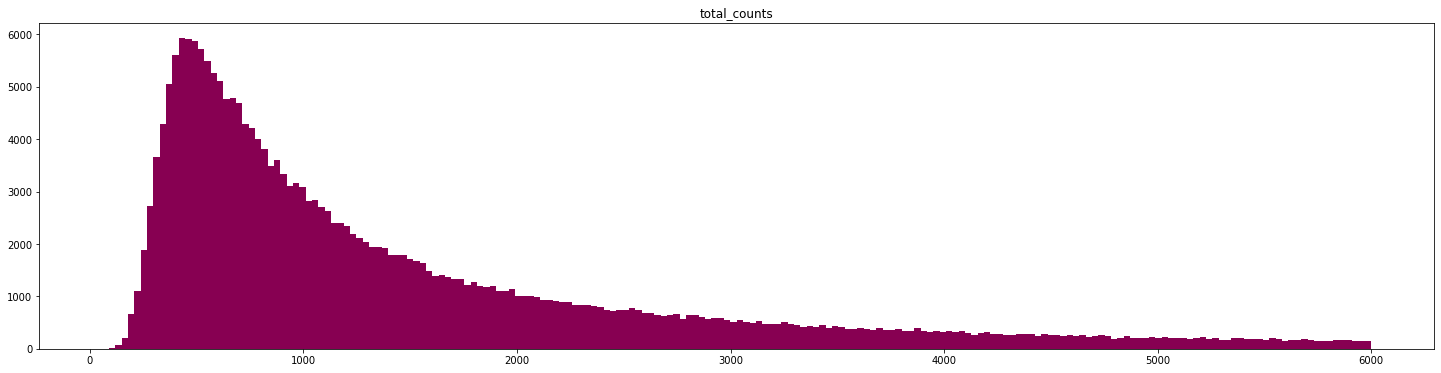

In [17]:
ad.var.hist(column = 'total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

- Remove peaks in ENCODE blacklist

https://www.nature.com/articles/s41598-019-45839-z

In [18]:
ad.var['ENCODE_blacklist'].sum()

754

In [19]:
ad = ad[:, ad.var['ENCODE_blacklist'] == 0]
ad

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 155699 × 227415
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

- Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)

In [20]:
ad = ad[:, ad.var.peak_width > 210]
ad = ad[:, ad.var.peak_width < 1500]
ad

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 155699 × 211332
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

array([[<AxesSubplot:title={'center':'peak_width'}>]], dtype=object)

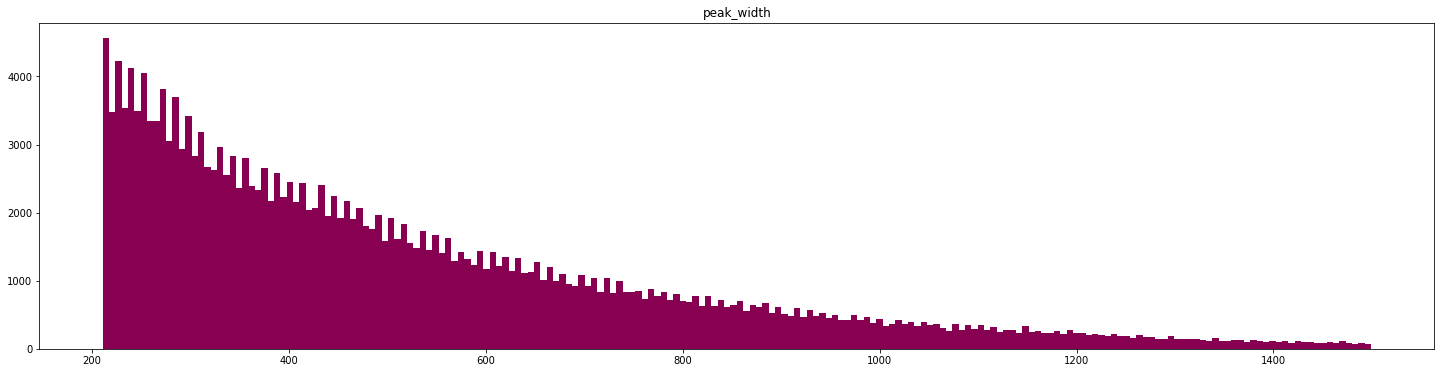

In [21]:
ad.var.hist(column = 'peak_width', bins = 200, grid = False, figsize = (25,6), color = '#870052')

- Filter peaks that are not accessible in at least 10% of cells from a coarse cluster

In [22]:
min_frac = 0.1
# min_frac = 0.01

- Load cluster information from cellatac outputs

In [23]:
clusters = pd.read_table(cellatac_outdir_1158 + 'qc/seurat-clades.tsv', header = None, index_col = 0)
clusters.columns = ["cellatac_clusters"]
ad.obs = clusters.loc[ad.obs_names]
ad

AnnData object with n_obs × n_vars = 155699 × 211332
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

- Add cluster matrix

In [24]:
n_clusters = len(np.unique(ad.obs[["cellatac_clusters"]]))
print('number of clusters:', n_clusters)
clus_mat = np.empty([ad.n_obs, n_clusters])
for cl in np.unique(ad.obs[["cellatac_clusters"]]):
    clus_mat[np.where(ad.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)
clus_mat[clus_mat != 1 ] = 0

number of clusters: 32


/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [25]:
cl_peak_mat = np.dot(clus_mat.T, ad.layers["binary_raw"])

In [26]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T  # normalise?

In [27]:
ad = ad[:, cl_peak_frac.max(0) > min_frac]
ad

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 155699 × 66842
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

## Add SangerID and other cell metadata

In [28]:
# metadata_snATAC
# snATAC=pd.read_csv('/nfs/team205/kk18/data/cellatac/tic-1050/6reg-v2_snATAC_metadata.csv',index_col=0)
snATAC=pd.read_csv('/nfs/team205/heart/cellatac/tic-1050/6reg-v2_snATAC_metadata.csv',index_col=0)
snATAC['dataset']=snATAC['Region']
snATAC.rename(columns={"Region": "Region_Coarse"}, inplace=True)


In [29]:
# metadata_Multiome
# Multiome=pd.read_csv('/nfs/team205/kk18/data/cellatac/tic-1050/6reg-v2_Multiome_metadata.csv')
Multiome=pd.read_csv('/nfs/team205/heart/metadata/multiome_metadata_6reg_plus_SAN.csv')

Multiome['dataset']='Multiome'
# Multiome['dataset']=''
# Multiome.loc[Multiome.query('Donor==3').index,'dataset']='Multiome_1'
# Multiome.loc[Multiome.query('Donor==7').index,'dataset']='Multiome_1'
# Multiome.loc[Multiome.query('Donor==8').index,'dataset']='Multiome_2'
# Multiome['Donor']=['D'+str(x) for x in Multiome['Donor']]

In [30]:
# cellatac_code to sangerID
cellmeta_tagmap = pd.read_table(cellatac_outdir_1158 + 'cellmetadata/tagmap.txt', header=None)
cellmeta_tagmap['cellatac_code']=[x.split('-')[0] for x in cellmeta_tagmap[0]]
cellmeta_tagmap['sangerID']=[x.split('-')[0] for x in cellmeta_tagmap[1]]
code2ID2meta = cellmeta_tagmap[['cellatac_code','sangerID']].copy()
code2ID2meta.drop_duplicates(inplace=True)

In [31]:
# cellatac_code to sangerID to metadata
ID2meta=pd.concat([snATAC[['SangerID','dataset','Donor','Region_Coarse']],Multiome[['SangerID','dataset','Donor','Region_Coarse', 'Region_Fine']]],axis=0)
code2ID2meta = code2ID2meta.merge(ID2meta, how='left', left_on='sangerID', right_on='SangerID')
code2ID2meta.drop(['SangerID'], axis=1, inplace=True)
code2ID2meta.head()

,cellatac_code,sangerID,dataset,Donor,Region_Coarse,Region_Fine
0,01,HCAHeart8374324,LV,D5,LV,NaN
1,02,HCAHeart8374325,RV,D6,RV,NaN
2,03,HCAHeart8374326,LA,D7,LA,NaN
3,04,HCAHeart8374327,LA,D5,LA,NaN
4,05,HCAHeart8374328,LV,D6,LV,NaN


In [32]:
ad.obs

,cellatac_clusters
01-AAACGAATCAAACCCA-1,26
01-AAACTGCAGACCCTAT-1,12
01-AAAGGATAGGCACTAG-1,12
01-AAAGGGCAGCGAGCTA-1,11
01-AAAGGGCAGTGATATG-1,13
...,...
36-TTTGTGTTCACAGACT-1,0
36-TTTGTGTTCCTCACTA-1,0
36-TTTGTGTTCTCCTCTT-1,0
36-TTTGTTGGTCACAGAC-1,0


In [33]:
# adding sample info to adata.obs (regions for snATAC and Multiome-t1 and t2)
ad.obs['cellatac_code']=[x.split('-')[0] for x in ad.obs.index]

Trying to set attribute `.obs` of view, copying.


In [34]:
ad.obs

,cellatac_clusters,cellatac_code
01-AAACGAATCAAACCCA-1,26,01
01-AAACTGCAGACCCTAT-1,12,01
01-AAAGGATAGGCACTAG-1,12,01
01-AAAGGGCAGCGAGCTA-1,11,01
01-AAAGGGCAGTGATATG-1,13,01
...,...,...
36-TTTGTGTTCACAGACT-1,0,36
36-TTTGTGTTCCTCACTA-1,0,36
36-TTTGTGTTCTCCTCTT-1,0,36
36-TTTGTTGGTCACAGAC-1,0,36


In [35]:
# adding sample info to adata.obs (regions for snATAC and Multiome-t1 and t2)
ad.obs['cellatac_code']=[x.split('-')[0] for x in ad.obs.index]

index=ad.obs_names
ad.obs=ad.obs.merge(code2ID2meta, how='left', on='cellatac_code')
ad.obs.set_index(index, inplace=True)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


In [36]:
ad.obs.Region_Fine.unique()

array([nan, 'LV FW ANTLAT EPI', 'LV FW ANTLAT ENDO', 'RV FW EPI',
       'RV FW ENDO', 'RAA', 'SAN'], dtype=object)

In [37]:
ad.obs.dataset.unique()

array(['LV', 'RV', 'LA', 'RA', 'SP', 'AX', 'Multiome'], dtype=object)

In [38]:
ad.obs['dataset']=ad.obs['dataset'].astype('category')
ad.obs['dataset'].cat.reorder_categories(['RA','LA','RV','LV','SP','AX','Multiome'], inplace=True)

In [39]:
ad.obs['Region_Coarse'].unique()

array(['LV', 'RV', 'LA', 'RA', 'SP', 'AX', 'SAN'], dtype=object)

In [40]:
ad.obs['Region_Coarse']=ad.obs['Region_Coarse'].astype('category')
ad.obs['Region_Coarse'].cat.reorder_categories(['RA','LA','RV','LV','SP','AX','SAN'], inplace=True)

In [41]:
ad

AnnData object with n_obs × n_vars = 155699 × 66842
    obs: 'cellatac_clusters', 'cellatac_code', 'sangerID', 'dataset', 'Donor', 'Region_Coarse', 'Region_Fine'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

### Filter low quality nuclei

In [42]:
sc.pp.calculate_qc_metrics(ad, layer = "binary_raw", inplace = True)

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

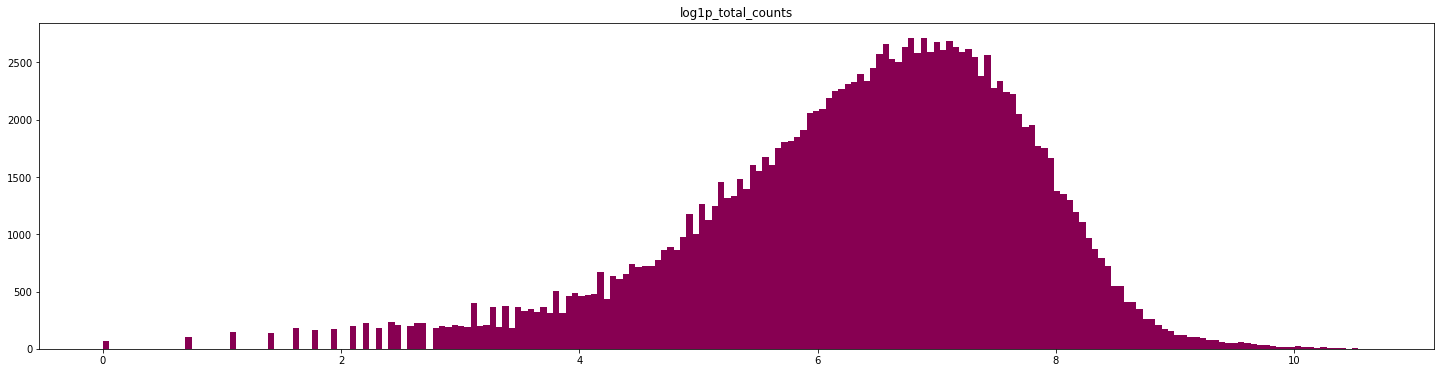

In [43]:
ad.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), 
            color = '#870052')

**filtering based on Signac-QC (No2 and No3)**

In [44]:
# Read in qualified cell barcode 
# Multiome_QCed=pd.read_table('/nfs/team205/kk18/data/mapped/cellranger-arc101/6reg-v2_MultiomeATAC_Signac-QCed-barcodes.txt', header=None)

mainDir = '/lustre/scratch117/cellgen/team205/dm19/kazu/heart/mapped/'
Multiome_QCed=pd.read_table(mainDir + "6reg-v2_MultiomeATAC_Signac-QCed-barcodes.txt", header=None)

snATAC_QCed=pd.read_table('/nfs/team205/heart/mapped/cellranger-atac120/6reg-v2_snATAC_Signac-QCed-barcodes.txt', header=None)

QCed = pd.concat([Multiome_QCed, snATAC_QCed])
QCed

,0
0,HCAHeart9508819_AAACATGCAGCAGGTA-1
1,HCAHeart9508819_AAACATGCATAGCTGC-1
2,HCAHeart9508819_AAACCAACAAGGTGCA-1
3,HCAHeart9508819_AAACCAACACTTAACG-1
4,HCAHeart9508819_AAACCAACAGCCGCTA-1
...,...
48093,HCAHeart8374344_TTTGGTTTCATTGCCC-1
48094,HCAHeart8374344_TTTGGTTTCGTTACAG-1
48095,HCAHeart8374344_TTTGTGTAGTACAACA-1
48096,HCAHeart8374344_TTTGTGTCACTGTCGG-1


In [45]:
Multiome_QCed

,0
0,HCAHeart9508819_AAACATGCAGCAGGTA-1
1,HCAHeart9508819_AAACATGCATAGCTGC-1
2,HCAHeart9508819_AAACCAACAAGGTGCA-1
3,HCAHeart9508819_AAACCAACACTTAACG-1
4,HCAHeart9508819_AAACCAACAGCCGCTA-1
...,...
63584,HCAHeartST10773171_HCAHeartST10781448_TACCAGGT...
63585,HCAHeartST10773171_HCAHeartST10781448_TATCCAGC...
63586,HCAHeartST10773171_HCAHeartST10781448_TCATTACT...
63587,HCAHeartST10773171_HCAHeartST10781448_TGATTAGT...


In [46]:
ad.obs.head()

,cellatac_clusters,cellatac_code,sangerID,dataset,Donor,Region_Coarse,Region_Fine,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
01-AAACGAATCAAACCCA-1,26,01,HCAHeart8374324,LV,D5,LV,NaN,8525,9.050876,8525.0,9.050876,0.586510,1.173021,2.346041,5.865103
01-AAACTGCAGACCCTAT-1,12,01,HCAHeart8374324,LV,D5,LV,NaN,29,3.401197,29.0,3.401197,100.000000,100.000000,100.000000,100.000000
01-AAAGGATAGGCACTAG-1,12,01,HCAHeart8374324,LV,D5,LV,NaN,3719,8.221479,3719.0,8.221479,1.344447,2.688895,5.377790,13.444474
01-AAAGGGCAGCGAGCTA-1,11,01,HCAHeart8374324,LV,D5,LV,NaN,6986,8.851807,6986.0,8.851807,0.715717,1.431434,2.862869,7.157171
01-AAAGGGCAGTGATATG-1,13,01,HCAHeart8374324,LV,D5,LV,NaN,1989,7.595890,1989.0,7.595890,2.513826,5.027652,10.055304,25.138260


In [47]:
# Concatenate sample ID and barcodes 
ad.obs['sangerID'] = ad.obs['sangerID'].astype('str')
ad.obs['barcode']  = [x[3:] for x in ad.obs_names]
ad.obs['fullbarcode'] = ad.obs['sangerID'] + '_' + ad.obs['barcode']
ad.obs['oribarcode'] = ad.obs_names 
ad.obs.set_index('fullbarcode', inplace=True)
ad.obs.head()

,cellatac_clusters,cellatac_code,sangerID,dataset,Donor,Region_Coarse,Region_Fine,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,barcode,oribarcode
fullbarcode,,,,,,,,,,,,,,,,,
HCAHeart8374324_AAACGAATCAAACCCA-1,26,01,HCAHeart8374324,LV,D5,LV,NaN,8525,9.050876,8525.0,9.050876,0.586510,1.173021,2.346041,5.865103,AAACGAATCAAACCCA-1,01-AAACGAATCAAACCCA-1
HCAHeart8374324_AAACTGCAGACCCTAT-1,12,01,HCAHeart8374324,LV,D5,LV,NaN,29,3.401197,29.0,3.401197,100.000000,100.000000,100.000000,100.000000,AAACTGCAGACCCTAT-1,01-AAACTGCAGACCCTAT-1
HCAHeart8374324_AAAGGATAGGCACTAG-1,12,01,HCAHeart8374324,LV,D5,LV,NaN,3719,8.221479,3719.0,8.221479,1.344447,2.688895,5.377790,13.444474,AAAGGATAGGCACTAG-1,01-AAAGGATAGGCACTAG-1
HCAHeart8374324_AAAGGGCAGCGAGCTA-1,11,01,HCAHeart8374324,LV,D5,LV,NaN,6986,8.851807,6986.0,8.851807,0.715717,1.431434,2.862869,7.157171,AAAGGGCAGCGAGCTA-1,01-AAAGGGCAGCGAGCTA-1
HCAHeart8374324_AAAGGGCAGTGATATG-1,13,01,HCAHeart8374324,LV,D5,LV,NaN,1989,7.595890,1989.0,7.595890,2.513826,5.027652,10.055304,25.138260,AAAGGGCAGTGATATG-1,01-AAAGGGCAGTGATATG-1


In [48]:
# Do filtering
ad=ad[ad.obs.index.isin(QCed[0])]
ad

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 79208 × 66842
    obs: 'cellatac_clusters', 'cellatac_code', 'sangerID', 'dataset', 'Donor', 'Region_Coarse', 'Region_Fine', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'barcode', 'oribarcode'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

array([[<AxesSubplot:title={'center':'log1p_total_counts'}>]],
      dtype=object)

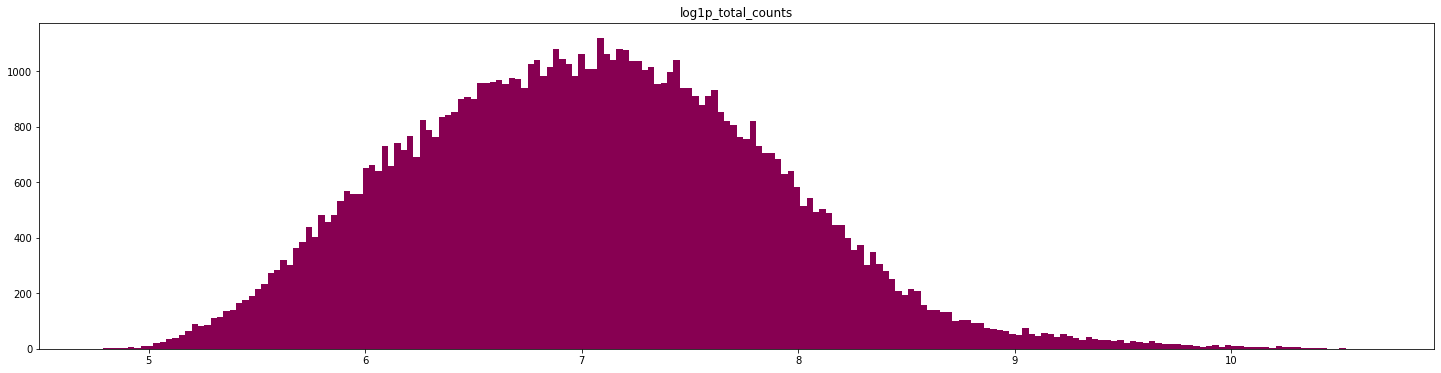

In [49]:
ad.obs.hist(column = 'log1p_total_counts', bins = 200, grid = False, figsize = (25,6), color = '#870052')

### Write output anndata

In [50]:
# adata.write(output["h5ad"])
# adata.write(outdir + experiment_prefix + '_filtered.h5ad')

outdir = '/nfs/team205/heart/anndata_objects/atac_filtered_by_tss_distance/'

ad.write(outdir + experiment_prefix + '_with_SAN_filtered_tss_distance.h5ad')

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cellatac_code' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sangerID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Donor' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Region_Fine' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'barcode' as categorical


In [51]:
ad.obs['dataset'].value_counts()

Multiome    31110
LV           9109
AX           8809
SP           8123
RA           7569
LA           7282
RV           7206
Name: dataset, dtype: int64

In [52]:
ad.obs['Region_Coarse'].value_counts()

LV    22906
RA    17313
SP    11919
LA    10352
AX     9208
RV     7510
Name: Region_Coarse, dtype: int64

In [53]:
ad.obs.head()

,cellatac_clusters,cellatac_code,sangerID,dataset,Donor,Region_Coarse,Region_Fine,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,barcode,oribarcode
fullbarcode,,,,,,,,,,,,,,,,,
HCAHeart8374324_AAACGAATCAAACCCA-1,26,01,HCAHeart8374324,LV,D5,LV,nan,8525,9.050876,8525.0,9.050876,0.586510,1.173021,2.346041,5.865103,AAACGAATCAAACCCA-1,01-AAACGAATCAAACCCA-1
HCAHeart8374324_AAAGGATAGGCACTAG-1,12,01,HCAHeart8374324,LV,D5,LV,nan,3719,8.221479,3719.0,8.221479,1.344447,2.688895,5.377790,13.444474,AAAGGATAGGCACTAG-1,01-AAAGGATAGGCACTAG-1
HCAHeart8374324_AAAGGGCAGCGAGCTA-1,11,01,HCAHeart8374324,LV,D5,LV,nan,6986,8.851807,6986.0,8.851807,0.715717,1.431434,2.862869,7.157171,AAAGGGCAGCGAGCTA-1,01-AAAGGGCAGCGAGCTA-1
HCAHeart8374324_AAAGGGCAGTGATATG-1,13,01,HCAHeart8374324,LV,D5,LV,nan,1989,7.595890,1989.0,7.595890,2.513826,5.027652,10.055304,25.138260,AAAGGGCAGTGATATG-1,01-AAAGGGCAGTGATATG-1
HCAHeart8374324_AAATGAGTCCGGGCAT-1,26,01,HCAHeart8374324,LV,D5,LV,nan,11291,9.331850,11291.0,9.331850,0.442831,0.885661,1.771322,4.428306,AAATGAGTCCGGGCAT-1,01-AAATGAGTCCGGGCAT-1


In [54]:
adata

NameError: name 'adata' is not defined